# Vault of vaults strategy

- Based on `04`
- Tweak basket construction criteria to bump the yield a bit

# Set up

Set up Trading Strategy data client.


In [1]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode, set_notebook_logging

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


logger = logging.getLogger("strategy")



Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


## Chain configuration

- Choose target chains and their vults

In [2]:
from eth_defi.token import USDC_NATIVE_TOKEN
from eth_defi.token import USDT_NATIVE_TOKEN
from eth_defi.token import WRAPPED_NATIVE_TOKEN

from tradingstrategy.chain import ChainId
from tradingstrategy.lending import LendingProtocolType

CHAIN_ID = ChainId.arbitrum


# We define our main trading universe,
# and then Ethereum mainnet as a validation set
match CHAIN_ID:
    case ChainId.arbitrum:

        EXCHANGES = ("uniswap-v2", "uniswap-v3")
        SUPPORTING_PAIRS = [
            (ChainId.arbitrum, "uniswap-v3", "WETH", "USDC", 0.0005),
        ]
        LENDING_RESERVES = None
        PREFERRED_STABLECOIN = USDC_NATIVE_TOKEN[CHAIN_ID].lower()


        VAULTS = [
            (ChainId.arbitrum, "0x58bfc95a864e18e8f3041d2fcd3418f48393fe6a"), # Plutus Hedge Token
            (ChainId.arbitrum, "0x959f3807f0aa7921e18c78b00b2819ba91e52fef"), # gmUSDC
            (ChainId.arbitrum, "0xd3443ee1e91af28e5fb858fbd0d72a63ba8046e0"), # gTrade (Gains) USDC
            (ChainId.arbitrum, "0x75288264fdfea8ce68e6d852696ab1ce2f3e5004"), # Hype++
            (ChainId.arbitrum, "0x4b6f1c9e5d470b97181786b26da0d0945a7cf027"), # Hypertrim USDC
            (ChainId.arbitrum, "0x0b2b2b2076d95dda7817e785989fe353fe955ef9"), # Staked USDai
            (ChainId.arbitrum, "0x64ca76e2525fc6ab2179300c15e343d73e42f958"), # Clearstar high yielsd USDC
            (ChainId.arbitrum, "0x7e97fa6893871a2751b5fe961978dccb2c201e65"), # Gauntlet
            (ChainId.arbitrum, "0x1a996cb54bb95462040408c06122d45d6cdb6096"), # Fluid
            (ChainId.arbitrum, "0xa91267a25939b2b0f046013fbf9597008f7f014b"), # IPOR USDC Arbirum optimise
            (ChainId.arbitrum, "0x05d28a86e057364f6ad1a88944297e58fc6160b3"), # Euler Arbitrum Yield USDC 

            # Some smaller entries to mix in
            (ChainId.arbitrum, "0xc8248953429d707c6a2815653eca89846ffaa63b"), # Curve LLAMMA asdCRV / crvUSD
            (ChainId.arbitrum, "0xf63b7f49b4f5dc5d0e7e583cfd79dc64e646320c"), # Auto finance Tokemak ARB/USDC
            (ChainId.arbitrum, "0xeeaf2ccb73a01deb38eca2947d963d64cfde6a32"), # Curve LLAMMA CRV / crvUSD
            (ChainId.arbitrum, "0xe5d6eb448ac5a762c1ebe8cd1692b9cd08025176"), # DAMM stablecoin fund

        ]        

        BENCHMARK_PAIRS = [
            (ChainId.arbitrum, "uniswap-v3", "WETH", "USDC", 0.0005),
        ]

        # Exclude Euro vaults, etc.
        # ALLOWED_VAULT_DENOMINATION_TOKENS = {"USDC", "USDT", "USDC.e"}
        ALLOWED_VAULT_DENOMINATION_TOKENS = {"USDC"}
    
    case ChainId.base:
        raise NotImplementedError()
    case ChainId.ethereum:
        raise NotImplementedError()
    case ChainId.binance:
        raise NotImplementedError()
    case ChainId.avalanche:
        raise NotImplementedError()
    case _:
        raise NotImplementedError(f"Chain not supported: {CHAIN_ID}")

## Parameters

- Collection of parameters used in the calculations

In [3]:
import datetime

import pandas as pd


from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.default_routing_options import TradeRouting

from tradeexecutor.utils.jupyter_notebook_name import get_notebook_id


class Parameters:

    id = get_notebook_id(globals())

    # We trade 1h candle
    candle_time_bucket = TimeBucket.d1
    cycle_duration = CycleDuration.cycle_7d
    
    chain_id = CHAIN_ID
    exchanges = EXCHANGES
    
    #
    # Basket size, risk and balancing parametrs.
    #   
    min_asset_universe = 5  # How many assets we need in the asset universe to start running the index
    max_assets_in_portfolio = 4  # How many assets our basket can hold once
    allocation = 0.95  # Allocate all cash to volatile pairs
    # min_rebalance_trade_threshold_pct = 0.05  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 500.0  # Don't make buys less than this amount
    sell_rebalance_min_threshold = 100.0
    sell_threshold = 0.05  # Sell if asset is more than 5% of the portfolio
    per_position_cap_of_pool = 0.33  # Never own more than % of the lit liquidity of the trading pool
    max_concentration = 0.25 # How large % can one asset be in a portfolio once
    min_portfolio_weight = 0.0050  # Close position / do not open if weight is less than 50 BPS

    # How long 
    # Needed to calculate weights
    rolling_returns_bars = 32

    min_tvl = 50_000  # Minimum TVL in the vault before it can be considered investable

    #     
    #
    # Backtesting only
    # Limiting factor: Aave v3 on Base starts at the end of DEC 2023
    #
    backtest_start = datetime.datetime(2025, 1, 1)
    backtest_end = datetime.datetime(2025, 12, 1)
    initial_cash = 100_000

    #
    # Live only
    #
    routing = TradeRouting.default
    required_history_period = datetime.timedelta(days=365*3)
    slippage_tolerance = 0.0060  # 0.6% 
    assummed_liquidity_when_data_missings = 10_000
    

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [4]:

from pathlib import Path
from typing import Callable
from tradingstrategy.pair import PandasPairUniverse


from eth_defi.vault.vaultdb import DEFAULT_RAW_PRICE_DATABASE

from tradingstrategy.utils.token_filter import add_base_quote_address_columns
from tradingstrategy.utils.token_filter import filter_for_exchange_slugs
from tradingstrategy.utils.token_filter import filter_pairs_default
from tradingstrategy.utils.token_filter import filter_for_selected_pairs
from tradingstrategy.utils.token_extra_data import load_token_metadata
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume
from tradingstrategy.utils.token_extra_data import load_token_metadata
from tradingstrategy.alternative_data.vault import load_vault_database


from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.analysis.pair import display_strategy_universe
from tradeexecutor.strategy.pandas_trader.trading_universe_input import CreateTradingUniverseInput
from tradeexecutor.analysis.vault import display_vaults



# Hack to support vault data exposure to live trading universe creation
from dotenv import load_dotenv
load_dotenv(override=True)  # Loads variables from .env file


def create_trading_universe(
    input: CreateTradingUniverseInput,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset

    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    execution_context = input.execution_context
    client = input.client
    timestamp = input.timestamp
    parameters = input.parameters or Parameters  # Some CLI commands do not support yet passing this
    universe_options = input.universe_options

    if execution_context.live_trading:
        # Live trading, send strategy universe formation details
        # to logs
        debug_printer = logger.info
    else:
        # Jupyter notebook inline output
        debug_printer = print

    chain_id = parameters.chain_id

    debug_printer(f"Preparing trading universe on chain {chain_id.get_name()}")

    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    # TODO: PandasPairUniverse(buidl_index=True) - speed this up by skipping index building
    all_pairs_df = client.fetch_pair_universe().to_pandas()
    pairs_df= filter_for_selected_pairs(
        all_pairs_df,
        SUPPORTING_PAIRS,
    )    

    debug_printer(f"We have total {len(all_pairs_df)} pairs in dataset and going to use {len(pairs_df)} pairs for the strategy")

    # Check which vaults we can include based on allowed deposit tokens for this backtest
    vault_universe = load_vault_database()
    total_vaults = vault_universe.get_vault_count()
    vault_universe = vault_universe.limit_to_vaults(VAULTS, check_all_vaults_found=False)
    vault_universe = vault_universe.limit_to_denomination(ALLOWED_VAULT_DENOMINATION_TOKENS)
    debug_printer(f"Loaded total {vault_universe.get_vault_count()} vaults from the total of {total_vaults} in vault database")

    # Default vault data bundle path for backtesting
    vault_bundled_price_data = DEFAULT_RAW_PRICE_DATABASE
    debug_printer(f"Using vault price data for backtesting from {vault_bundled_price_data}")

    dataset = load_partial_data(
        client=client,
        time_bucket=parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity=True,
        liquidity_time_bucket=TimeBucket.d1,
        lending_reserves=LENDING_RESERVES,
        vaults=vault_universe,
        vault_bundled_price_data=vault_bundled_price_data,
        check_all_vaults_found=True,
    )

    debug_printer("Creating strategy universe with price feeds and vaults")
    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset=PREFERRED_STABLECOIN,
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
        forward_fill_until=timestamp,
    )

    # Dump our vault data and check for data errors
    display_vaults(
        vault_universe,
        strategy_universe,
        execution_mode=execution_context.mode,
        printer=debug_printer,  
    )

    return strategy_universe


universe_input = CreateTradingUniverseInput(
    execution_context=notebook_execution_context,
    client=client,
    timestamp=None,
    parameters=parameters,
    universe_options=UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context),
    execution_model=None,
)

strategy_universe = create_trading_universe(universe_input)


print("Universe creation done")

df = display_strategy_universe(
    strategy_universe, 
    sort_key="base",
    sort_numeric=False,
    limit=75,
    show_token_risk=True,
    show_tokensniffer=True,
)

df = df.head(10)

from IPython.display import display, HTML
html_table = df.to_html(escape=False, classes='table table-striped')
display(HTML(html_table))


Preparing trading universe on chain Arbitrum One
We have total 387449 pairs in dataset and going to use 1 pairs for the strategy
Loaded total 11 vaults from the total of 19525 in vault database
Using vault price data for backtesting from /Users/moo/.tradingstrategy/vaults/cleaned-vault-prices-1h.parquet


Loading TVL/liquidity data for 1 pairs:   0%|          | 0/1 [00:00<?, ?it/s]

Creating strategy universe with price feeds and vaults
Vault check list


Chain                                       Vault  \
0   Arbitrum  0xd3443ee1e91af28e5fb858fbd0d72a63ba8046e0   
1   Arbitrum  0x959f3807f0aa7921e18c78b00b2819ba91e52fef   
2   Arbitrum  0x1a996cb54bb95462040408c06122d45d6cdb6096   
3   Arbitrum  0xa91267a25939b2b0f046013fbf9597008f7f014b   
4   Arbitrum  0x75288264fdfea8ce68e6d852696ab1ce2f3e5004   
5   Arbitrum  0x58bfc95a864e18e8f3041d2fcd3418f48393fe6a   
6   Arbitrum  0x7e97fa6893871a2751b5fe961978dccb2c201e65   
7   Arbitrum  0x05d28a86e057364f6ad1a88944297e58fc6160b3   
8   Arbitrum  0xf63b7f49b4f5dc5d0e7e583cfd79dc64e646320c   
9   Arbitrum  0x4b6f1c9e5d470b97181786b26da0d0945a7cf027   
10  Arbitrum  0x64ca76e2525fc6ab2179300c15e343d73e42f958   

                            Name       Protocol Denomination Status  
0    gTrade (Gains Network USDC)  gains-network         USDC     OK  
1                         gmUSDC          umami         USDC     OK  
2                 Fluid USD Coin          fluid         USDC     OK  
3   IPOR USDC Arbitrum Optimizer           ipor         USDC     OK  
4                         HYPE++     d2-finance         USDC     OK  
5             Plutus Hedge Token         plutus         USDC     OK  
6             Gauntlet USDC Core         morpho         USDC     OK  
7      Euler Arbitrum Yield USDC          euler         USDC     OK  
8                 Tokemak arbUSD   auto-finance         USDC     OK  
9                 Hyperithm USDC         morpho         USDC     OK  
10     Clearstar High Yield USDC         morpho         USDC     OK

Universe creation done
Results limited to first 75 entries


## Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [5]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 12 assets
Category trading pairs 12
Benchmark trading pairs 0


# Indicators

- Precalculate indicators used by the strategy

In [6]:
import pandas as pd
from IPython.display import HTML
import pandas_ta

from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSource
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount
from tradeexecutor.strategy.pandas_trader.indicator_decorator import IndicatorRegistry
from tradeexecutor.analysis.indicator import display_indicators
from tradingstrategy.utils.groupeduniverse import resample_candles


indicators = IndicatorRegistry()

empty_series = pd.Series([], index=pd.DatetimeIndex([]))


@indicators.define()
def rolling_returns(
    close: pd.Series,
    rolling_returns_bars: int = 60,
) -> pd.Series:
    """Calculate rolling returns over a period"
    """

    windowed = close.rolling(
        window=rolling_returns_bars, 
        min_periods=2,
    ).max()
    series = (close / windowed)
    return series


@indicators.define(source=IndicatorSource.tvl)
def tvl(
    close: pd.Series,
    execution_context: ExecutionContext,
    timestamp: pd.Timestamp,
) -> pd.Series:
    """Get TVL series for a pair.

    - Because TVL data is 1d and we use 1h everywhere else, we need to forward fill

    - Use previous hourly close as the value
    """
    if execution_context.live_trading:
        # TVL is daily data.
        # We need to forward fill until the current hour.
        # Use our special ff function.        
        assert isinstance(timestamp, pd.Timestamp), f"Live trading needs forward-fill end time, we got {timestamp}"
        from tradingstrategy.utils.forward_fill import forward_fill
        df = pd.DataFrame({"close": close})
        df_ff = forward_fill(
            df,
            Parameters.candle_time_bucket.to_frequency(),
            columns=("close",),
            forward_fill_until=timestamp,
        )
        series = df_ff["close"]
        return series
    else:
        return close.resample("1h").ffill()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_universe)
def tvl_inclusion_criteria(   
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """The pair must have min XX,XXX USD one-sided TVL to be included.

    - If the Uniswap pool does not have enough ETH or USDC deposited, skip the pair as a scam

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(tvl)
    mask = series >= min_tvl
    # Turn to a series of lists
    mask_true_values_only = mask[mask == True]
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(
    source=IndicatorSource.strategy_universe
)
def trading_availability_criteria(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Is pair tradeable at each hour.

    - The pair has a price candle at that
    - Mitigates very corner case issues that TVL/liquidity data is per-day whileas price data is natively per 1h
      and the strategy inclusion criteria may include pair too early hour based on TVL only,
      leading to a failed attempt to rebalance in a backtest
    - Only relevant for backtesting issues if we make an unlucky trade on the starting date
      of trading pair listing

    :return:
        Series with with index (timestamp) and values (list of pair ids trading at that hour)
    """
    # Trading pair availability is defined if there is a open candle in the index for it.
    # Because candle data is forward filled, we should not have any gaps in the index.
    candle_series = strategy_universe.data_universe.candles.df["open"]
    pairs_per_timestamp = candle_series.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return pairs_per_timestamp


@indicators.define(
    dependencies=[
        tvl_inclusion_criteria,
        trading_availability_criteria
    ],
    source=IndicatorSource.strategy_universe
)
def inclusion_criteria(
    strategy_universe: TradingStrategyUniverse,
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Pairs meeting all of our inclusion criteria.

    - Give the tradeable pair set for each timestamp

    :return:
        Series where index is timestamp and each cell is a list of pair ids matching our inclusion criteria at that moment
    """

    # Filter out benchmark pairs like WETH in the tradeable pair set
    benchmark_pair_ids = set(strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS)

    tvl_series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={
            "min_tvl": min_tvl,
        },
    )

    trading_availability_series = dependency_resolver.get_indicator_data(trading_availability_criteria)

    #
    # Process all pair ids as a set and the final inclusion
    # criteria is union of all sub-criterias
    #

    df = pd.DataFrame({
        "tvl_pair_ids": tvl_series,
        "trading_availability_pair_ids": trading_availability_series,
    })

    # https://stackoverflow.com/questions/33199193/how-to-fill-dataframe-nan-values-with-empty-list-in-pandas
    df = df.fillna("").apply(list)

    def _combine_criteria(row):
        final_set = set(row["tvl_pair_ids"]) & \
                    set(row["trading_availability_pair_ids"])
        return final_set - benchmark_pair_ids

    union_criteria = df.apply(_combine_criteria, axis=1)

    # Inclusion criteria data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=union_criteria.index.min(),
        end=union_criteria.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    reindexed = union_criteria.reindex(full_index, fill_value=[])
    return reindexed


@indicators.define(dependencies=(tvl_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def tvl_included_pair_count(
        min_tvl: USDollarAmount,
        dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={"min_tvl": min_tvl},
    )
    series = series.apply(len)

    # TVL data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=series.index.min(),
        end=series.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    # Reindex and fill NaN with zeros
    reindexed = series.reindex(full_index, fill_value=0)
    return reindexed


@indicators.define(dependencies=(inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def all_criteria_included_pair_count(
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Series where each timestamp is the list of pairs meeting all inclusion criteria.

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        "inclusion_criteria",
        parameters={
            "min_tvl": min_tvl, 
        },
    )
    return series.apply(len)


@indicators.define(source=IndicatorSource.strategy_universe)
def trading_pair_count(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Get number of pairs that trade at each timestamp.

    - Pair must have had at least one candle before the timestamp to be included

    - Exclude benchmarks pairs we do not trade

    :return:
        Series with pair count for each timestamp
    """

    benchmark_pair_ids = {strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS}

    # Get pair_id, timestamp -> timestamp, pair_id index
    series = strategy_universe.data_universe.candles.df["open"]    
    swap_index = series.index.swaplevel(0, 1)

    seen_pairs = set()
    seen_data = {}

    for timestamp, pair_id in swap_index:
        if pair_id in benchmark_pair_ids:
            continue
        seen_pairs.add(pair_id)
        seen_data [timestamp] = len(seen_pairs)

    series = pd.Series(seen_data.values(), index=list(seen_data.keys()))
    return series



@indicators.define(
    source=IndicatorSource.dependencies_only_per_pair,
    dependencies=[
        rolling_returns, 
    ]
)
def signal(
    rolling_returns_bars: int,
    candle_time_bucket: TimeBucket,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver    
) -> pd.Series:
    """Calculate weighting criteria ("signal") as the past returns of the rolling returns window.
    """

    rolling_returns = dependency_resolver.get_indicator_data(
            "rolling_returns",
        parameters={
            "rolling_returns_bars": rolling_returns_bars,            
        },
        pair=pair,
    )
    return rolling_returns


display_indicators(indicators)


# Calculate all indicators where parameters have changed and store the result on disk
indicator_data = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=indicators.create_indicators,
    parameters=parameters,
)


We have 9 indicators:


Reading cached indicators rolling_returns, tvl, tvl_inclusion_criteria, trading_availability_criteria, inclusi…

Using indicator cache /Users/moo/.cache/indicators/arbitrum_1d_12_2024-01-18-2025-12-15_ff


Calculating indicators rolling_returns, tvl, tvl_inclusion_criteria, trading_availability_criteria, inclusion_…

Calculating indicators rolling_returns, tvl, tvl_inclusion_criteria, trading_availability_criteria, inclusion_…

# Trading universe charts

- Define charts used in backtesting and live execution



In [7]:
from plotly.graph_objects import Figure
from tradeexecutor.strategy.chart.definition import ChartRegistry, ChartKind, ChartInput
from tradeexecutor.strategy.chart.renderer import ChartBacktestRenderingSetup
from tradeexecutor.strategy.chart.standard.trading_universe import available_trading_pairs
from tradeexecutor.strategy.chart.standard.trading_universe import inclusion_criteria_check 
from tradeexecutor.strategy.chart.standard.volatility import volatility_benchmark
from tradeexecutor.strategy.chart.standard.signal import signal_comparison
from tradeexecutor.strategy.chart.standard.signal import price_vs_signal
from tradeexecutor.strategy.chart.standard.vault import all_vaults_share_price_and_tvl
from tradeexecutor.strategy.chart.standard.vault import vault_position_timeline
from tradeexecutor.strategy.chart.standard.vault import all_vault_positions
from tradeexecutor.strategy.chart.standard.equity_curve import equity_curve
from tradeexecutor.strategy.chart.standard.equity_curve import equity_curve_with_drawdown
from tradeexecutor.strategy.chart.standard.performance_metrics import performance_metrics
from tradeexecutor.strategy.chart.standard.weight import volatile_weights_by_percent
from tradeexecutor.strategy.chart.standard.weight import volatile_and_non_volatile_percent
from tradeexecutor.strategy.chart.standard.weight import equity_curve_by_asset
from tradeexecutor.strategy.chart.standard.weight import weight_allocation_statistics
from tradeexecutor.strategy.chart.standard.position import positions_at_end
from tradeexecutor.strategy.chart.standard.thinking import last_messages
from tradeexecutor.strategy.chart.standard.alpha_model import alpha_model_diagnostics
from tradeexecutor.strategy.chart.standard.profit_breakdown import trading_pair_breakdown
from tradeexecutor.strategy.chart.standard.trading_metrics import trading_metrics
from tradeexecutor.strategy.chart.standard.interest import lending_pool_interest_accrued
from tradeexecutor.strategy.chart.standard.interest import vault_statistics
from tradeexecutor.strategy.chart.standard.single_pair import trading_pair_positions
from tradeexecutor.strategy.chart.standard.single_pair import trading_pair_price_and_trades
from tradeexecutor.strategy.chart.standard.vault import all_vaults_share_price_and_tvl as _all_vaults_share_price_and_tvl


def equity_curve_with_benchmark(input: ChartInput) -> list[Figure]:
    """Add our benchmark token"""
    return equity_curve(
        input,
        benchmark_token_symbols=["ETH"],
    )


def all_vaults_share_price_and_tvl(input: ChartInput) -> list[Figure]:
    """Limit max_count"""
    return _all_vaults_share_price_and_tvl(
        input,
        max_count=2,
    )

# Define charts we use in backtesting and live trading
charts = ChartRegistry(default_benchmark_pairs=BENCHMARK_PAIRS)
charts.register(available_trading_pairs, ChartKind.indicator_all_pairs)
charts.register(inclusion_criteria_check, ChartKind.indicator_all_pairs)
charts.register(volatility_benchmark, ChartKind.indicator_multi_pair)
charts.register(signal_comparison, ChartKind.indicator_multi_pair)
charts.register(price_vs_signal, ChartKind.indicator_multi_pair)
charts.register(all_vaults_share_price_and_tvl, ChartKind.indicator_all_pairs)
charts.register(equity_curve_with_benchmark, ChartKind.state_all_pairs)
charts.register(equity_curve_with_drawdown, ChartKind.state_all_pairs)
charts.register(performance_metrics, ChartKind.state_all_pairs)
charts.register(volatile_weights_by_percent, ChartKind.state_all_pairs)
charts.register(volatile_and_non_volatile_percent, ChartKind.state_all_pairs)
charts.register(equity_curve_by_asset, ChartKind.state_all_pairs)
charts.register(weight_allocation_statistics, ChartKind.state_all_pairs)
charts.register(positions_at_end, ChartKind.state_all_pairs)
charts.register(last_messages, ChartKind.state_all_pairs)
charts.register(alpha_model_diagnostics, ChartKind.state_all_pairs)
charts.register(trading_pair_breakdown, ChartKind.state_all_pairs)
charts.register(trading_metrics, ChartKind.state_all_pairs)
charts.register(lending_pool_interest_accrued, ChartKind.state_all_pairs)
charts.register(vault_statistics, ChartKind.state_all_pairs)
charts.register(vault_position_timeline, ChartKind.state_single_vault_pair)
charts.register(all_vault_positions, ChartKind.state_single_vault_pair)
charts.register(trading_pair_positions, ChartKind.state_single_vault_pair)
charts.register(trading_pair_price_and_trades, ChartKind.state_single_vault_pair)
charts.register(inclusion_criteria_check, ChartKind.indicator_all_pairs)

# Chart rendering pre-backtest execution
chart_renderer = ChartBacktestRenderingSetup(
    registry=charts,
    strategy_input_indicators=indicator_data,
    backtest_end_at=Parameters.backtest_end,
)


# Chart rendering pre-backtest execution
chart_renderer = ChartBacktestRenderingSetup(
    registry=charts,
    strategy_input_indicators=indicator_data,
    backtest_end_at=Parameters.backtest_end,
)

## Available pairs

- Number of pairs available to trade every month


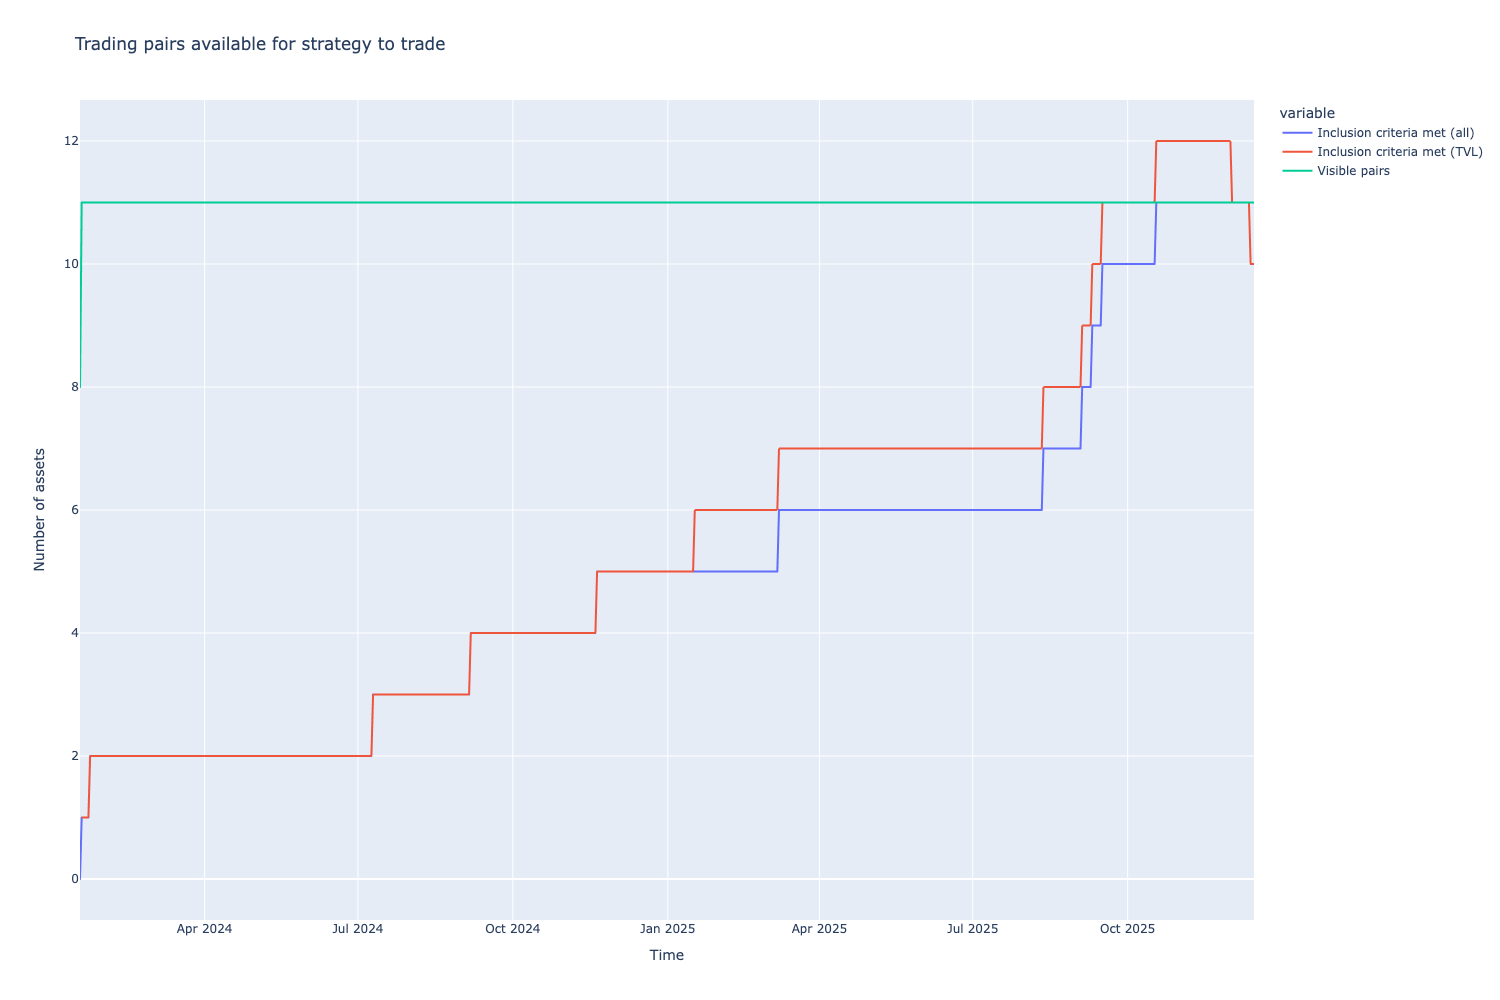

Inclusion criteria met (all)  Inclusion criteria met (TVL)  \
2025-12-11                            11                          11.0   
2025-12-12                            11                          11.0   
2025-12-13                            10                          10.0   
2025-12-14                            10                          10.0   
2025-12-15                            10                          10.0   

            Visible pairs  
2025-12-11             11  
2025-12-12             11  
2025-12-13             11  
2025-12-14             11  
2025-12-15             11

In [8]:
fig, df = chart_renderer.render(available_trading_pairs, with_dataframe=True)
fig.show()
display(df.tail(5))

## Inclusion criteria checks

- Examine when different pairs got included and what was the pair status during the inclusion

In [9]:

df = chart_renderer.render(inclusion_criteria_check)

print(f"First appearances of {len(df)} trading pairs, when they meet all inclusion criteria:")

with pd.option_context("display.float_format", "{:,.2f}".format):
    display(df.head(5))


First appearances of 11 trading pairs, when they meet all inclusion criteria:


Included at             Ticker            DEX  TVL at inclusion  \
283455471  2024-01-19        gmUSDC-USDC          umami         74,836.20   
276842208  2024-01-24         gUSDC-USDC  gains-network        231,998.38   
282812566  2024-07-10         fUSDC-USDC          fluid        100,011.11   
276758859  2024-09-06  ipUSDCfusion-USDC           ipor        688,693.24   
272519172  2024-11-20        HYPE++-USDC     d2-finance        124,696.15   

             TVL at end  
283455471    179,983.74  
276842208 15,637,980.71  
282812566 69,800,677.03  
276758859    330,963.65  
272519172  3,704,154.64

## Vault TVL and share price data

- Examine returns of the vaults used in this backtest

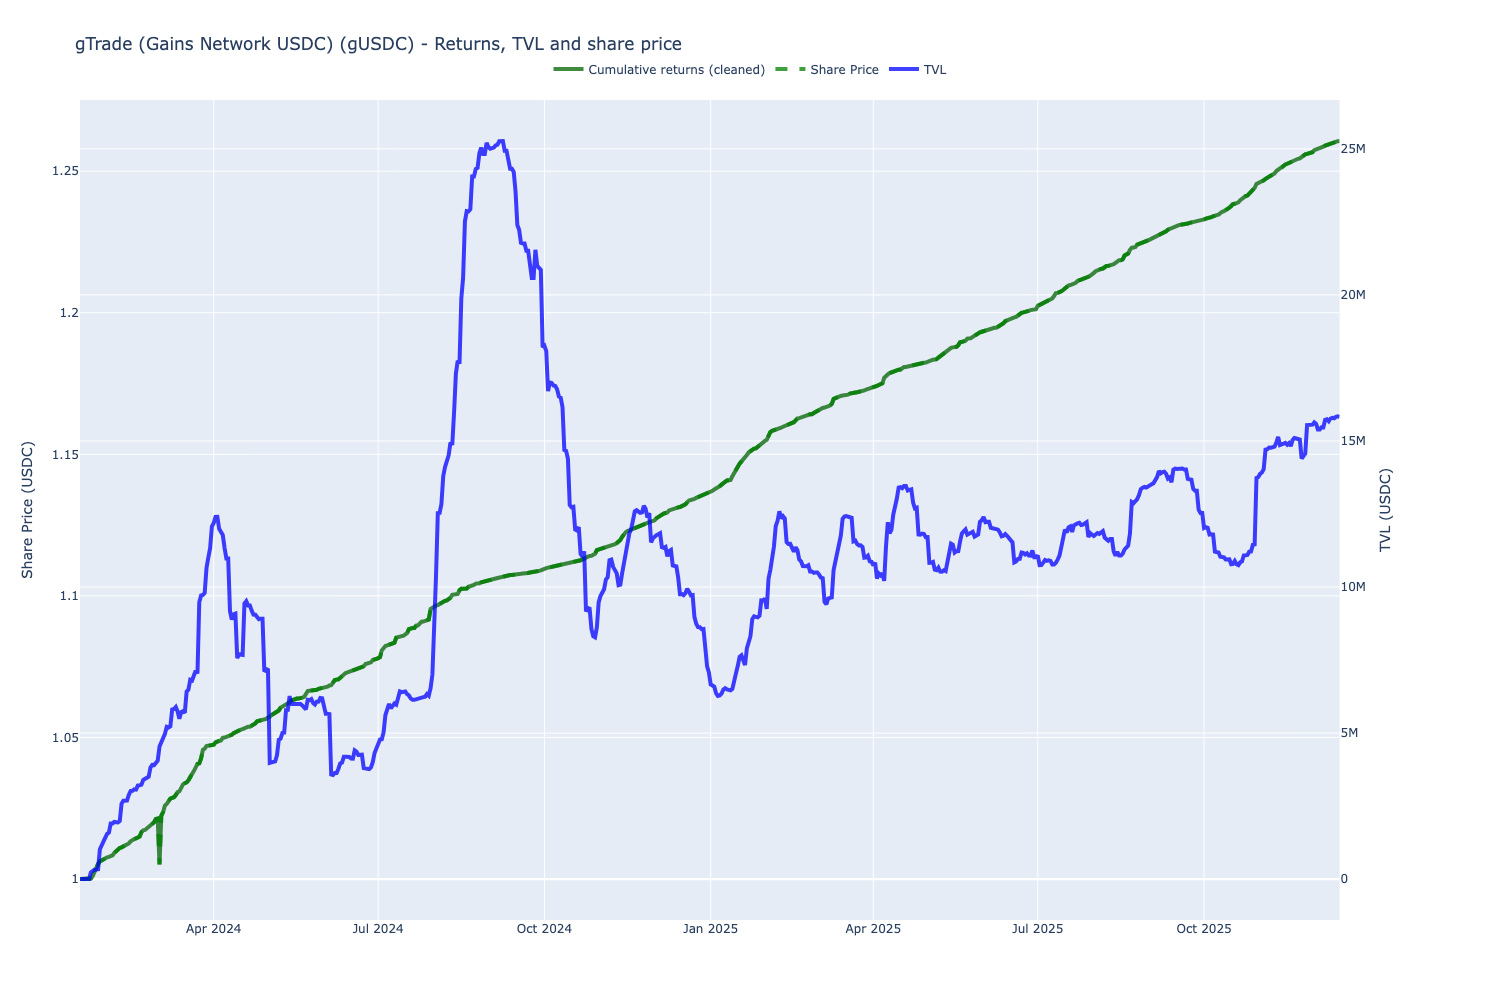

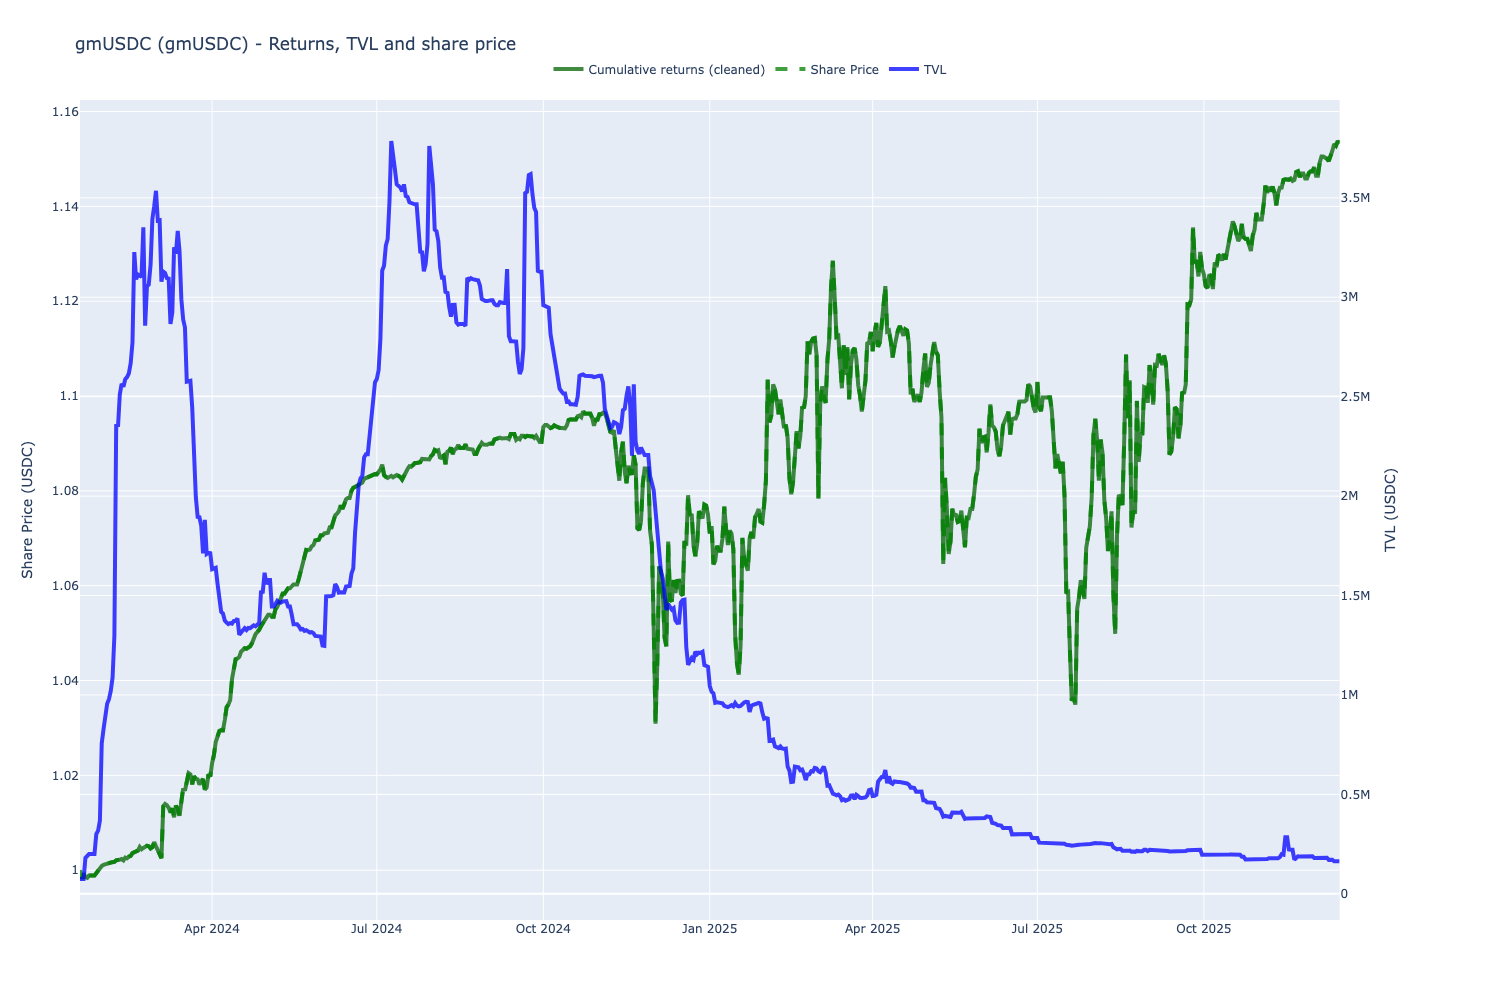

In [10]:
from tradeexecutor.analysis.vault import visualise_vaults

figures = chart_renderer.render(all_vaults_share_price_and_tvl)
for fig in figures:
    fig.show()

# Time range for backtest

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [11]:
series = indicator_data.get_indicator_series("all_criteria_included_pair_count")

exceeds_threshold = series > Parameters.min_asset_universe
# Get the first date where the condition is True
backtest_start = Parameters.backtest_start
backtest_end = Parameters.backtest_end

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2025-01-01 00:00:00 - 2025-12-01 00:00:00


# Algorithm and backtest

- Run the backtest

In [12]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput, IndicatorDataNotFoundWithinDataTolerance
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh, weight_equal
from tradeexecutor.utils.dedent import dedent_any
from tradeexecutor.strategy.pandas_trader.yield_manager import YieldManager, YieldRuleset, YieldWeightingRule, YieldDecisionInput
from tradeexecutor.strategy.execution_context import ExecutionContext, ExecutionMode


_cached_start_times: dict[int, pd.Timestamp] = {}

def create_yield_rules(
    timestamp: pd.Timestamp,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
) -> YieldRuleset:
    """Create yield rules for the strategy."""
    weights = []
    for vault_spec in VAULTS:
        vault_pair = strategy_universe.get_pair_by_smart_contract(vault_spec[1])
        if vault_pair not in _cached_start_times:
            price_df = strategy_universe.data_universe.candles.get_samples_by_pair(vault_pair.internal_id)
            assert price_df is not None
            index_entry = price_df.index[0]
            assert isinstance(index_entry, tuple)
            _cached_start_times[vault_pair] = index_entry[1]
        
        availability = _cached_start_times[vault_pair]
        if timestamp > availability:
            weights.append(
            YieldWeightingRule(
                pair=vault_pair, 
                max_concentration=1.00,
                max_pool_participation=0.05,
            ),
            )

    if len(weights) == 0:
        return None
    
    return YieldRuleset(
        position_allocation=parameters.allocation,
        buffer_pct=parameters.directional_trade_yield_buffer_pct,
        cash_change_tolerance_usd=parameters.yield_flow_dust_threshold,
        weights=weights
    )


def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    portfolio = position_manager.get_current_portfolio()
    equity = portfolio.get_total_equity()
    
    # All gone, stop doing decisions
    if input.execution_context.mode == ExecutionMode.backtesting:
        if equity < parameters.initial_cash * 0.10:
            return []
            
    # Build signals for each pair
    alpha_model = AlphaModel(
        timestamp,
        close_position_weight_epsilon=parameters.min_portfolio_weight,  # 10 BPS is our min portfolio weight
    )

    tvl_included_pair_count = indicators.get_indicator_value(
        "tvl_included_pair_count",
    )

    # Get pairs included in this rebalance cycle.
    # This includes pair that have been pre-cleared in inclusion_criteria()
    # with volume, volatility and TVL filters
    included_pairs = indicators.get_indicator_value(
        "inclusion_criteria",
        na_conversion=False,
    )
    if included_pairs is None:
        included_pairs = []

    # Set signal for each pair
    signal_count = 0
    for pair_id in included_pairs:
        pair = strategy_universe.get_pair_by_id(pair_id)

        if not state.is_good_pair(pair):
            # Tradeable flag set to False, etc.
            continue

        pair_signal = indicators.get_indicator_value("signal", pair=pair)
        if pair_signal is None:
            continue

        weight = pair_signal

        if weight < 0:
            continue

        alpha_model.set_signal(
            pair,
            weight,
        )

        # Diagnostics reporting
        signal_count += 1

    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    equity = portfolio.get_total_equity()
    portfolio_target_value = equity * parameters.allocation

    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_passthrouh)
    # alpha_model.assign_weights(method=weight_by_1_slash_n)

    #
    # Normalise weights and cap the positions
    #
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=0.0,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=parameters.max_concentration,
    )

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=False,
    )
    alpha_model.calculate_target_positions(position_manager)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)

    # rebalance_threshold_usd = portfolio_target_value * parameters.min_rebalance_trade_threshold_pct
    rebalance_threshold_usd = parameters.individual_rebalance_min_threshold_usd

    assert rebalance_threshold_usd > 0.1, "Safety check tripped - something like wrong with strat code"
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  # Don't bother with trades under XXXX USD
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
        sell_rebalance_min_threshold=parameters.sell_rebalance_min_threshold,
        execution_context=input.execution_context,
    )

    # # Move cash in and out yield managed to cover spot positions
    # yield_result = None 
    # if parameters.use_managed_yield:

    #     rules = create_yield_rules(
    #         timestamp,
    #         parameters, 
    #         strategy_universe,
    #     )

    #     if rules is not None:
    #         yield_manager = YieldManager(
    #             position_manager=position_manager,
    #             rules=rules,
    #         )

    #         yield_input = YieldDecisionInput(
    #             execution_mode=input.execution_context.mode,
    #             cycle=input.cycle,
    #             timestamp=timestamp,
    #             total_equity=state.portfolio.get_total_equity(),
    #             directional_trades=trades,
    #             size_risk_model=size_risk_model,
    #             pending_redemptions=position_manager.get_pending_redemptions(),
    #         )

    #         yield_result = yield_manager.calculate_yield_management(yield_input)
    #         trades += yield_result.trades
        
    # Add verbal report about decision made/not made,
    # so it is much easier to diagnose live trade execution.
    # This will be readable in Discord/Telegram logging.
    if input.is_visualisation_enabled():
        try:
            top_signal = next(iter(alpha_model.get_signals_sorted_by_weight()))
            if top_signal.normalised_weight == 0:
                top_signal = None
        except StopIteration:
            top_signal = None

        rebalance_volume = sum(t.get_value() for t in trades)

        report = dedent_any(f"""
        Cycle: #{input.cycle}
        Rebalanced: {'👍' if alpha_model.is_rebalance_triggered() else '👎'}
        Open/about to open positions: {len(state.portfolio.open_positions)} 
        Max position value change: {alpha_model.max_position_adjust_usd:,.2f} USD
        Rebalance threshold: {alpha_model.position_adjust_threshold_usd:,.2f} USD
        Trades decided: {len(trades)}
        Pairs total: {strategy_universe.data_universe.pairs.get_count()}
        Pairs meeting inclusion criteria: {len(included_pairs)}
        Pairs meeting TVL inclusion criteria: {tvl_included_pair_count}        
        Signals created: {signal_count}
        Total equity: {portfolio.get_total_equity():,.2f} USD
        Cash: {position_manager.get_current_cash():,.2f} USD
        Investable equity: {alpha_model.investable_equity:,.2f} USD
        Accepted investable equity: {alpha_model.accepted_investable_equity:,.2f} USD
        Allocated to signals: {alpha_model.get_allocated_value():,.2f} USD
        Discarted allocation because of lack of lit liquidity: {alpha_model.size_risk_discarded_value:,.2f} USD
        Rebalance volume: {rebalance_volume:,.2f} USD
        """)

        # Most volatility pair signal weight (normalised): {max_vol_signal.normalised_weight * 100 if max_vol_signal else '-'} % (got {max_vol_signal.position_size_risk.get_relative_capped_amount() * 100 if max_vol_signal else '-'} % of asked size)
        if top_signal:
            assert top_signal.position_size_risk
            report += dedent_any(f"""
            Top signal pair: {top_signal.pair.get_ticker()}
            Top signal value: {top_signal.signal}
            Top signal weight: {top_signal.raw_weight}
            Top signal weight (normalised): {top_signal.normalised_weight * 100:.2f} % (got {top_signal.position_size_risk.get_relative_capped_amount() * 100:.2f} % of asked size)
            """)

        for flag, count in alpha_model.get_flag_diagnostics_data().items():
            report += f"Signals with flag {flag.name}: {count}\n"

        state.visualisation.add_message(
            timestamp,
            report,
        )

        state.visualisation.set_discardable_data("alpha_model", alpha_model)

    return trades  # Return the list of trades we made in this cycle


result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=indicators.create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
    start_at=backtest_start,
    end_at=backtest_end,
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

# Add state to the further charts
chart_renderer = ChartBacktestRenderingSetup(
    registry=charts,
    strategy_input_indicators=indicator_data,
    state=state,
)


Reading cached indicators rolling_returns, tvl, tvl_inclusion_criteria, trading_availability_criteria, inclusi…

Using indicator cache /Users/moo/.cache/indicators/arbitrum_1d_12_2024-01-18-2025-12-15_ff


  0%|          | 0/28857600 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 32 trades


# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [13]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

df = chart_renderer.render(performance_metrics)
display(df)

Strategy                  ETH
Start Period                        2024-12-30           2024-12-30
End Period                          2025-11-24           2025-11-24
Risk-Free Rate                            0.0%                 0.0%
Time in Market                           15.0%                98.0%
Cumulative Return                       14.93%              -18.75%
CAGR﹪                                   11.24%               -14.7%
Sharpe                                    4.15                 0.08
Prob. Sharpe Ratio                      100.0%               52.98%
Smart Sharpe                              3.96                 0.07
Sortino                                 189.32                 0.12
Smart Sortino                            180.6                 0.11
Sortino/√2                              133.87                 0.08
Smart Sortino/√2                         127.7                 0.08
Omega                                   181.01               181.01
Max Drawdown                            -0.08%              -60.05%
Longest DD Days                              7                  194
Volatility (ann.)                        3.72%               76.63%
Calmar                                  144.82                -0.24
Skew                                      6.95                 0.56
Kurtosis                                 58.21                 4.08
Expected Daily                           0.04%               -0.06%
Expected Monthly                         1.17%               -1.72%
Expected Yearly                           7.2%               -9.86%
Kelly Criterion                         97.33%                    -
Risk of Ruin                              0.0%                 0.0%
Daily Value-at-Risk                     -0.28%               -6.58%
Expected Shortfall (cVaR)               -0.28%               -6.58%
Max Consecutive Wins                         1                    9
Max Consecutive Losses                       1                    6
Gain/Pain Ratio                         180.01                 0.01
Gain/Pain (1M)                               -                 0.06
Payoff Ratio                              3.94                    -
Profit Factor                           181.01                 1.01
Common Sense Ratio                           -                 1.12
CPC Index                               697.12                    -
Tail Ratio                                   -                  1.1
Outlier Win Ratio                        22.72                 2.47
Outlier Loss Ratio                        -0.0                 1.85
MTD                                      0.79%              -23.28%
3M                                       2.96%              -38.16%
6M                                        9.1%               16.88%
YTD                                     14.93%              -18.75%
1Y                                      14.93%              -18.75%
3Y (ann.)                               11.24%               -14.7%
5Y (ann.)                               11.24%               -14.7%
10Y (ann.)                              11.24%               -14.7%
All-time (ann.)                         11.24%               -14.7%
Best Day                                  2.2%               21.79%
Worst Day                               -0.08%              -14.75%
Best Month                                2.5%                48.7%
Worst Month                               0.0%               -32.2%
Best Year                               14.93%                 0.0%
Worst Year                                0.0%              -18.75%
Avg. Drawdown                           -0.08%              -22.32%
Avg. Drawdown Days                           7                   52
Recovery Factor                         180.01                 0.09
Ulcer Index                                0.0                  0.3
Serenity Index                         11979.4                 0.01
Avg. Up Month             

# Equity curve

- Equity curve shows how your strategy accrues value over time

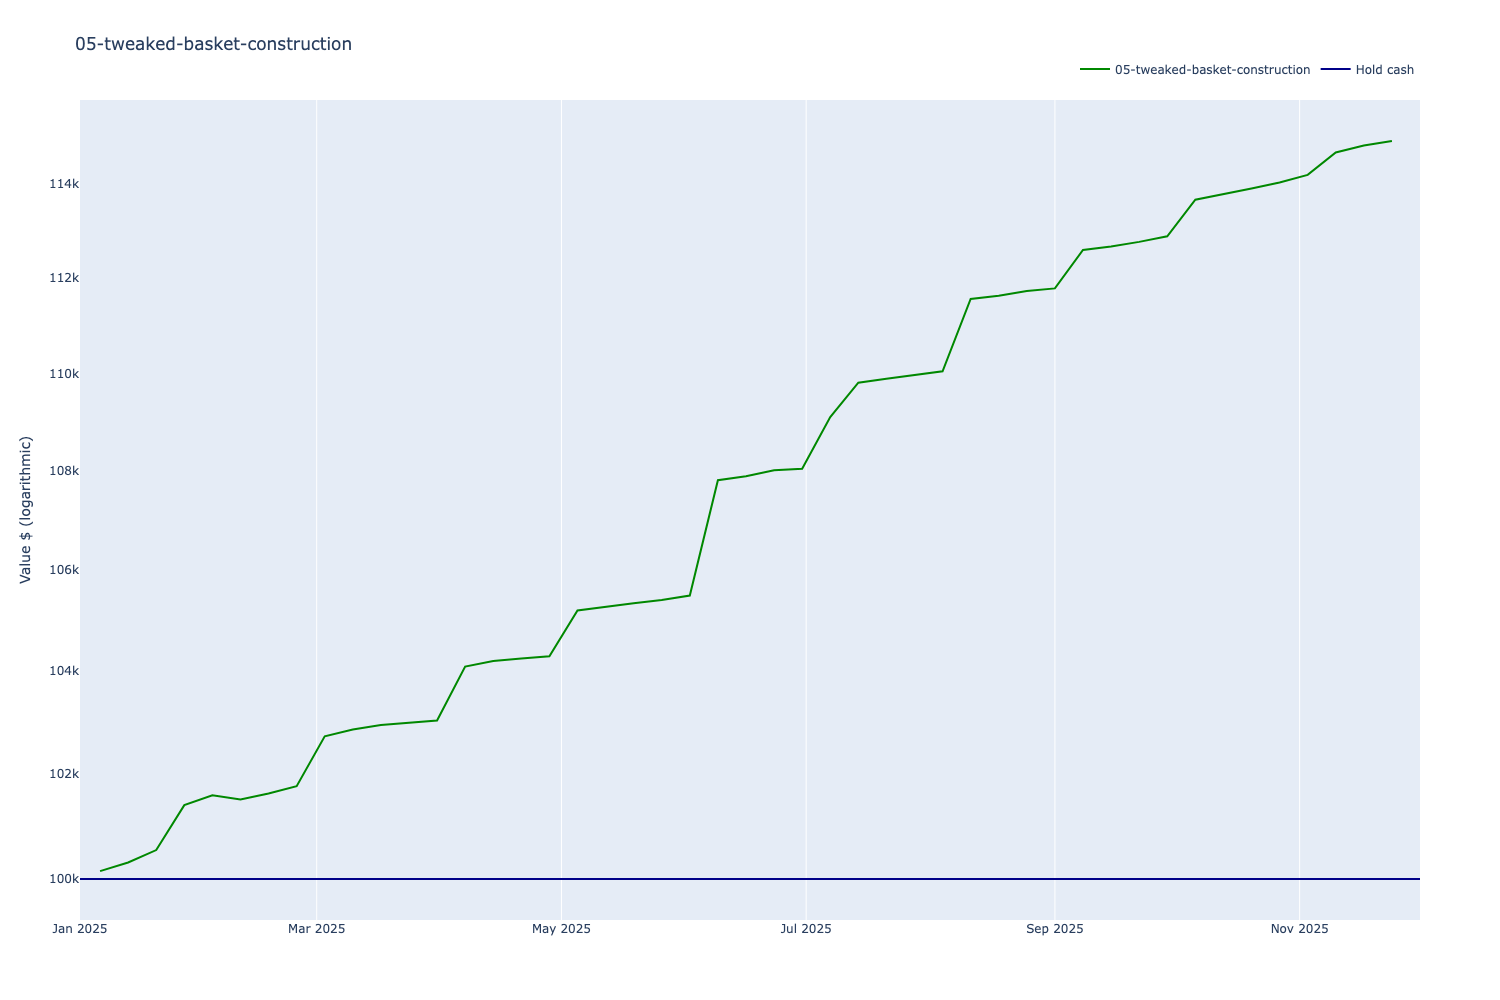

In [14]:
fig = chart_renderer.render(
    equity_curve_with_benchmark, 
)

fig.show()

## Equity curve with drawdown

- Linear curve

In [15]:

fig = chart_renderer.render(equity_curve_with_drawdown)

# Asset weights

- What assets were allocated over time
- Do both proportional % and USD weights

## Volatiles only

In [16]:
# fig = chart_renderer.render(volatile_weights_by_percent)
# fig.show()

print("Currently the strategy does not take directional positions")

Currently the strategy does not take directional positions


## Volatiles and non-volatiles

- Portfolio with cash, lending and vault positions

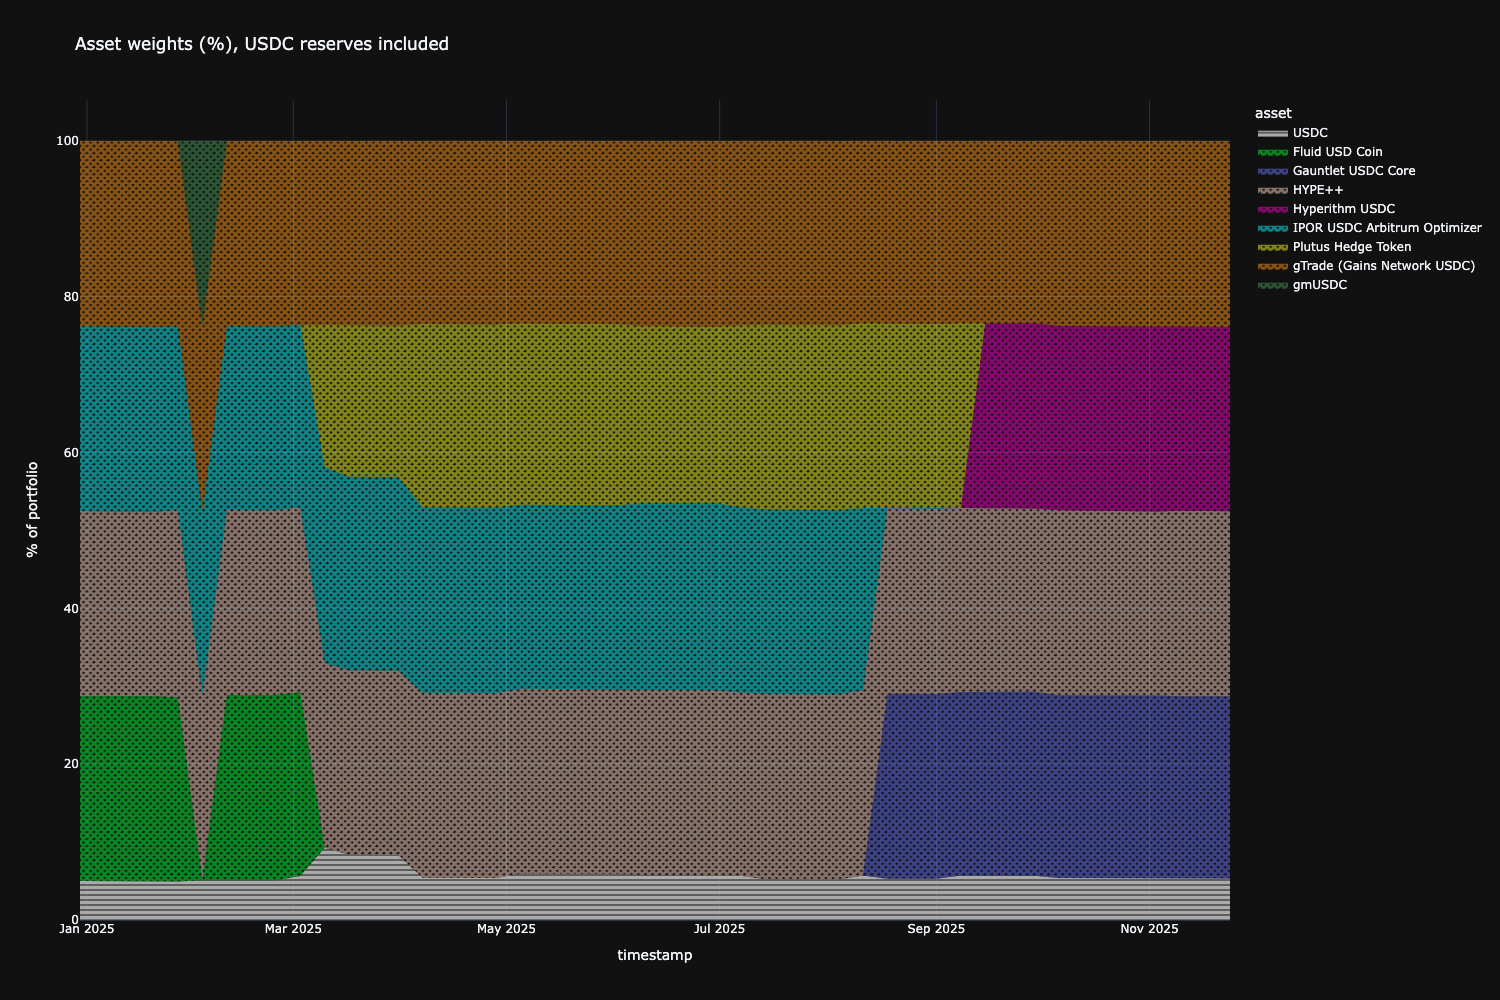

In [17]:

fig = chart_renderer.render(volatile_and_non_volatile_percent)
fig.show()
    

## Portfolio equity curve breakdown by asset

- Where did we make the profit

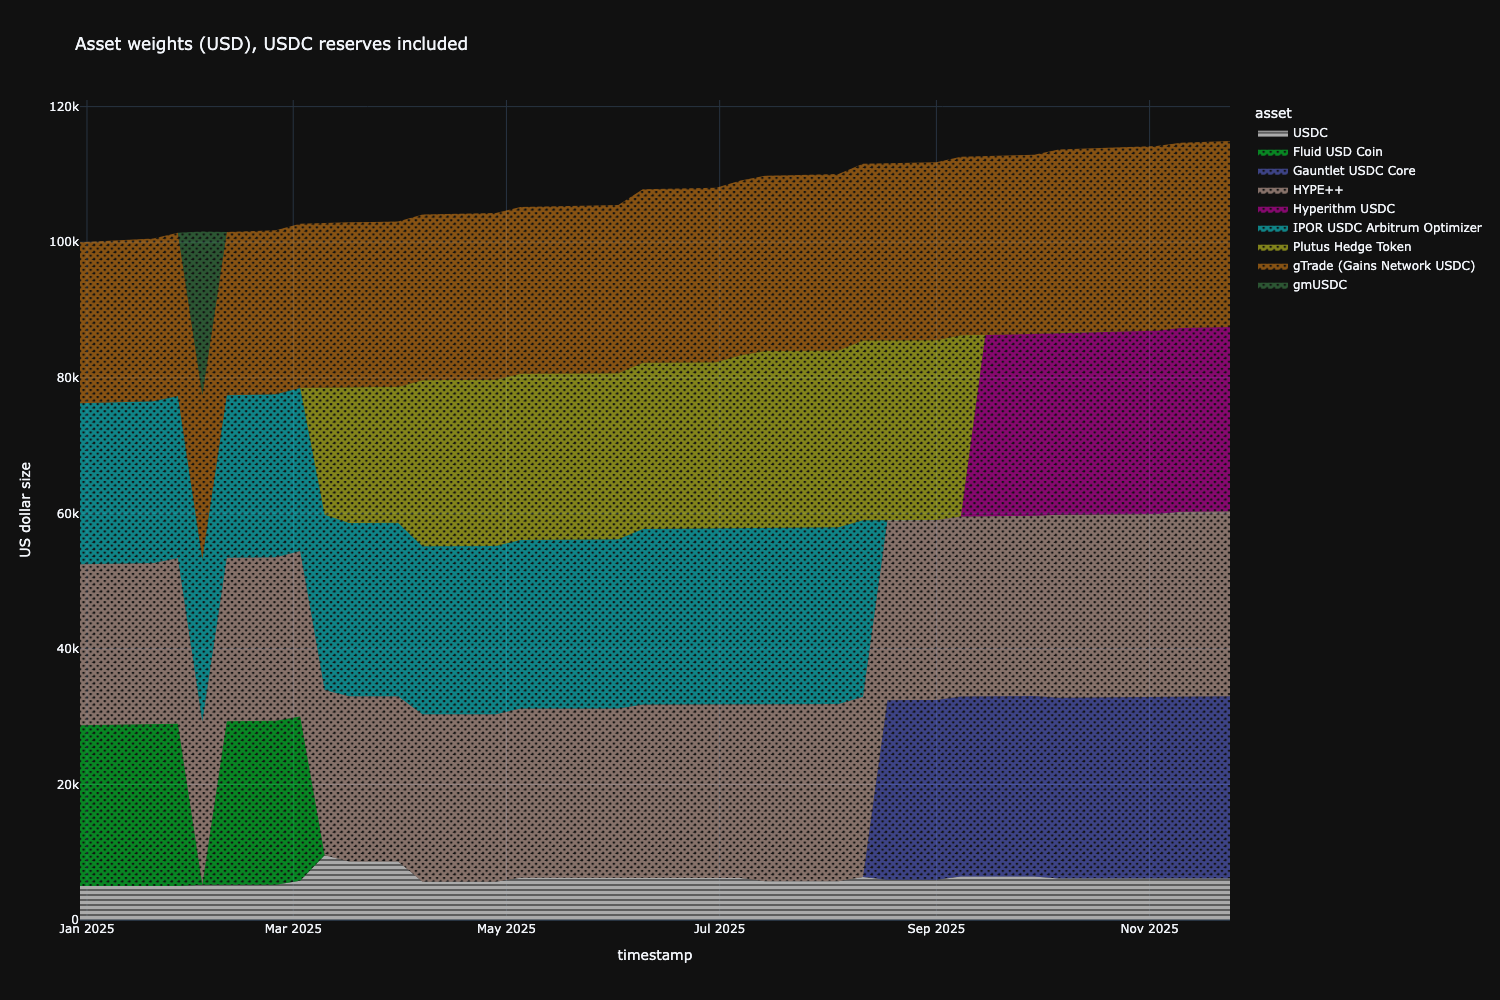

In [18]:
fig = chart_renderer.render(equity_curve_by_asset)
fig.show()

## Weight allocation statistics



In [19]:
stats = chart_renderer.render(weight_allocation_statistics)
display(stats)


At  \
Name                                                  
Max position (excluding USDC)   2025-11-24 00:00:00   
Min position (excluding USDC)   2025-03-10 00:00:00   
Mean position (excluding USDC)                        
Max position (excluding USDC)   2025-03-10 00:00:00   
Min position (excluding USDC)   2025-03-10 00:00:00   
Mean position (excluding USDC)                        
Max position (including USDC)   2025-03-10 00:00:00   
Min position (including USDC)   2025-01-27 00:00:00   
Mean position (including USDC)                        

                                                        Pair      Value Unit  
Name                                                                          
Max position (excluding USDC)    gTrade (Gains Network USDC)  27,448.83  USD  
Min position (excluding USDC)             Plutus Hedge Token  18,785.13  USD  
Mean position (excluding USDC)                                25,342.87  USD  
Max position (excluding USDC)   IPOR USDC Arbitrum Optimizer      27.69    %  
Min position (excluding USDC)             Plutus Hedge Token      20.13    %  
Mean position (excluding USDC)                                    25.00    %  
Max position (including USDC)   IPOR USDC Arbitrum Optimizer      25.12    %  
Min position (including USDC)                           USDC       4.93    %  
Mean position (including USDC)                                    20.00    %

# Positions at the end

Some example positions at the end


In [20]:
stats = chart_renderer.render(positions_at_end)
display(stats)

token         value
position_id                         
1                gUSDC  27448.833770
2               HYPE++  27283.948426
8              gtUSDCc  26894.116770
9            hyperUSDC  27183.263287

# Strategy thinking

- At the end of strategy
- Reverse order - last timestamp first

In [21]:
df = chart_renderer.render(last_messages)
display(df)

# Alpha model diagnostics data

- Dump out alpha model contents from the last cycle

In [22]:
df = chart_renderer.render(alpha_model_diagnostics)
display(df)

Signal    Asked size  Accepted size  Value adjust USD  \
Pair                                                                         
gmUSDC-USDC        0.998945             -            NaN          0.000000   
CSHYUSDC-USDC      1.000000             -            NaN          0.000000   
HYPE++-USDC        1.000000  27295.126023   27295.126023         11.177597   
arbUSD-USDC        1.000000             -            NaN          0.000000   
eUSDC-5-USDC       1.000000             -            NaN          0.000000   
fUSDC-USDC         1.000000             -            NaN          0.000000   
gUSDC-USDC         1.000000  27295.126023   27295.126023       -153.707747   
gtUSDCc-USDC       1.000000  27295.126023   27295.126023        401.009253   
hyperUSDC-USDC     1.000000  27295.126023   27295.126023        111.862736   
ipUSDCfusion-USDC  1.000000             -            NaN          0.000000   
plvHedge-USDC      1.000000             -            NaN          0.000000   

                   Weights (raw)  Weights (norm/cap)  Old weight  \
Pair                                                               
gmUSDC-USDC                  0.0                0.00    0.000000   
CSHYUSDC-USDC                0.0                0.00    0.000000   
HYPE++-USDC                  1.0                0.25    0.250748   
arbUSD-USDC                  0.0                0.00    0.000000   
eUSDC-5-USDC                 0.0                0.00    0.000000   
fUSDC-USDC                   0.0                0.00    0.000000   
gUSDC-USDC                   1.0                0.25    0.252264   
gtUSDCc-USDC                 1.0                0.25    0.247165   
hyperUSDC-USDC               1.0                0.25    0.249823   
ipUSDCfusion-USDC            0.0                0.00    0.000000   
plvHedge-USDC                0.0                0.00    0.000000   

                       Flipping       TVL                 Flags  
Pair                                                             
gmUSDC-USDC        none -> spot         0                        
CSHYUSDC-USDC      none -> spot         0                        
HYPE++-USDC             no flip   3536854  max_adjust_too_small  
arbUSD-USDC        none -> spot         0                        
eUSDC-5-USDC       none -> spot         0                        
fUSDC-USDC         none -> spot         0                        
gUSDC-USDC              no flip  15065240  max_adjust_too_small  
gtUSDCc-USDC            no flip  47136171  max_adjust_too_small  
hyperUSDC-USDC          no flip   3741234  max_adjust_too_small  
ipUSDCfusion-USDC  none -> spot         0                        
plvHedge-USDC      none -> spot         0

# Trading pair breakdown

- Trade success for each trading pair



In [23]:
df = chart_renderer.render(trading_pair_breakdown)
display(df)

# Trading metrics

- Trading cost, etc.

In [24]:
df = chart_renderer.render(trading_metrics)
display(df)


# Interest accrued

- How much profit our non-volatile positions generated

## Lending pools

- Calculate interest from lending pools (Aave, etc)

In [25]:
df = chart_renderer.render(lending_pool_interest_accrued)
display(df)

Metric  Value
0  Credit position count      0

# Vault performance

- Analyse the performance of our vaults

## Vault statistics 

- Calculate interest accrued on different vaults for the strategy

In [26]:
df = chart_renderer.render(vault_statistics)
display(df)

Metric              Value
0                Position count                  9
1         Total interest earned      14,926.85 USD
2                  Avg interest              8.15%
3                  Min interest            -33.38%
4                  Max interest             33.24%
5  Avg credit position duration  149 days, 8:00:00
6         Total deposit flow in     225,135.46 USD
7                   Min deposit         502.23 USD
8                   Avg deposit      14,070.97 USD
9                   Max deposit      26,758.19 USD

## Vault position list

- Display individual positions taken in the vaults

In [27]:
df = chart_renderer.render(all_vault_positions)
display(df)

Vault     Opened               Closed  \
Id                                                                 
1    gTrade (Gains Network USDC) 2024-12-30                    -   
2                         HYPE++ 2024-12-30                    -   
4                 Fluid USD Coin 2024-12-30  2025-02-03 00:00:00   
3   IPOR USDC Arbitrum Optimizer 2024-12-30  2025-08-18 00:00:00   
5                         gmUSDC 2025-02-03  2025-02-10 00:00:00   
6                 Fluid USD Coin 2025-02-10  2025-03-10 00:00:00   
7             Plutus Hedge Token 2025-03-10  2025-09-15 00:00:00   
8             Gauntlet USDC Core 2025-08-18                    -   
9                 Hyperithm USDC 2025-09-15                    -   

   Profit % annualised Profit USD Price on open Price on close Price diff %  \
Id                                                                            
1                10.98    2523.18          1.14           1.23         8.65   
2                33.64    7267.40          1.06           1.39        31.46   
4                11.33     245.66          1.04           1.05         1.03   
3                 5.08     841.76          1.02           1.06         3.45   
5               -28.46    -154.46          1.10           1.10        -0.64   
6                 9.24     164.05          1.05           1.05         0.68   
7                26.83    3230.70          1.00           1.14        13.63   
8                 5.12     383.48          1.00           1.00            -   
9                 7.76     425.07          1.00           1.00            -   

   Price diff % ann.  Deposits  Redeems  
Id                                       
1               7.96         3        1  
2              28.96         1        6  
4               0.10         1        1  
3               2.19         3        3  
5              -0.01         1        1  
6               0.05         1        1  
7               7.06         4        3  
8                  -         1        0  
9                  -         1        0

## Vault individual position timeline

- Show one of the vaults

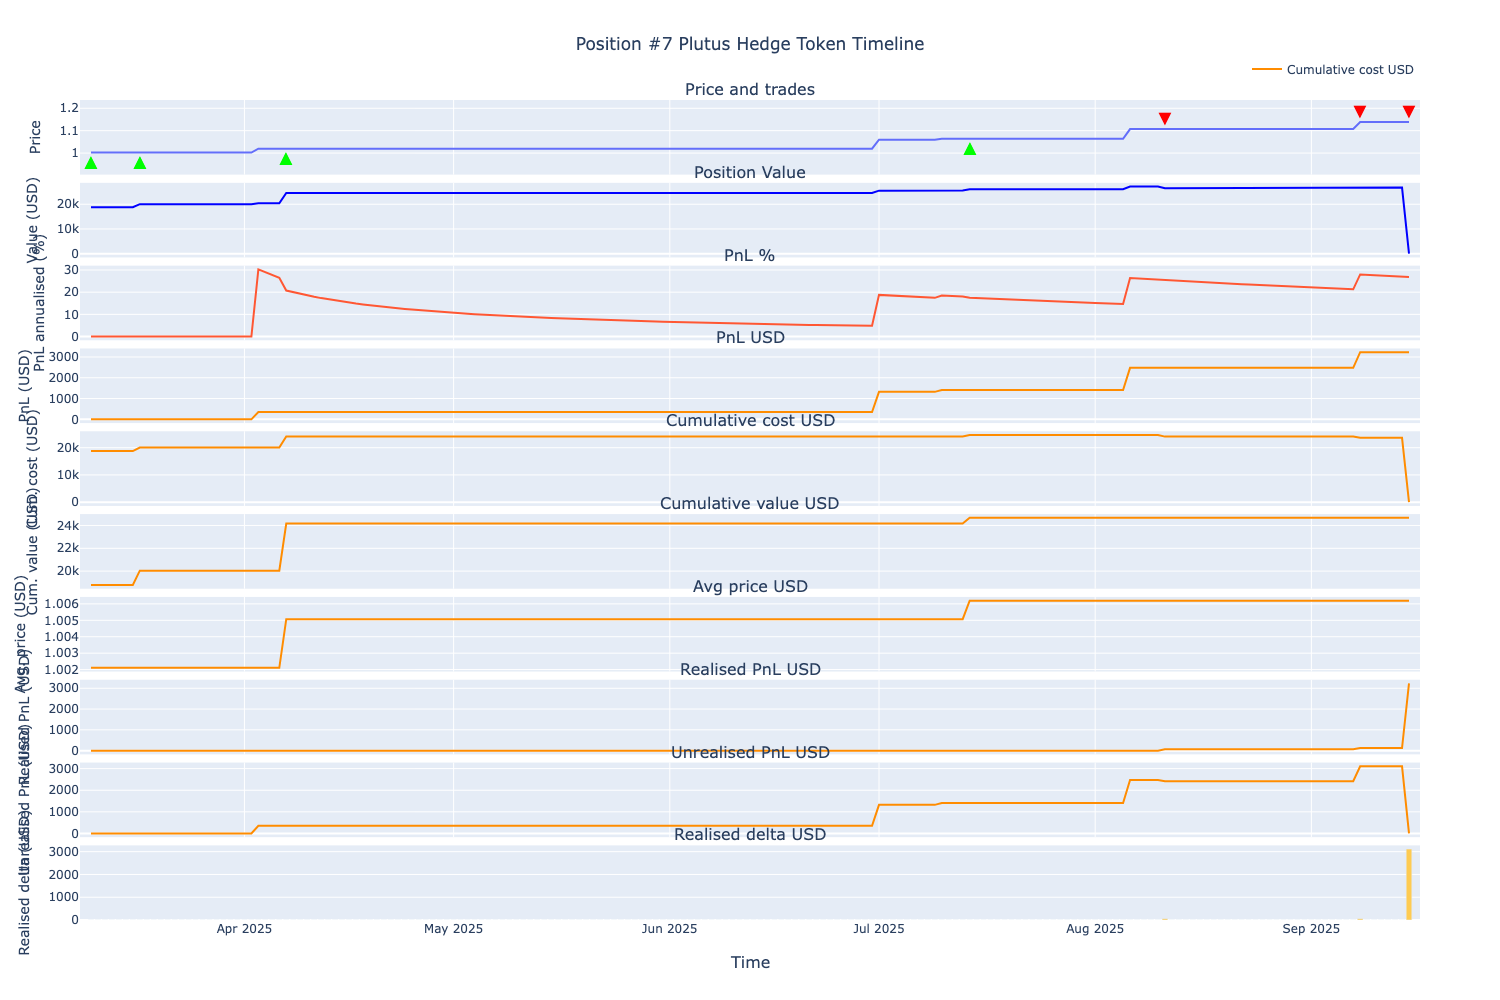

quantity         delta  executed_price  fee  cumulative_cost  \
timestamp                                                                      
2025-03-10  18745.615575  18745.615575        1.002108  0.0     1.878513e+04   
2025-03-11  18745.615575      0.000000        1.002108  0.0     1.878513e+04   
2025-03-16  18745.615575      0.000000        1.002108  0.0     1.878513e+04   
2025-03-17  19996.977704   1251.362129        1.002108  0.0     2.003913e+04   
2025-03-18  19996.977704      0.000000        1.002108  0.0     2.003913e+04   
2025-04-06  19996.977704      0.000000        1.002108  0.0     2.003913e+04   
2025-04-07  24044.515091   4047.537387        1.019689  0.0     2.416636e+04   
2025-04-08  24044.515091      0.000000        1.019689  0.0     2.416636e+04   
2025-07-13  24044.515091      0.000000        1.019689  0.0     2.416636e+04   
2025-07-14  24516.654394    472.139303        1.063733  0.0     2.466859e+04   
2025-07-15  24516.654394      0.000000        1.063733  0.0     2.466859e+04   
2025-08-10  24516.654394      0.000000        1.063733  0.0     2.466859e+04   
2025-08-11  23928.223177   -588.431217        1.107233  0.0     2.407651e+04   
2025-08-12  23928.223177      0.000000        1.107233  0.0     2.407651e+04   
2025-09-07  23928.223177      0.000000        1.107233  0.0     2.407651e+04   
2025-09-08  23482.278977   -445.944200        1.138729  0.0     2.362781e+04   
2025-09-09  23482.278977      0.000000        1.138729  0.0     2.362781e+04   
2025-09-14  23482.278977      0.000000        1.138729  0.0     2.362781e+04   
2025-09-15      0.000000 -23482.278977        1.138729  0.0    -3.637979e-12   

            cumulative_value  avg_price  mark_price         value  \
timestamp                                                           
2025-03-10      18785.131333   1.002108    1.002108  18785.131333   
2025-03-11      18785.131333   1.002108    1.002108  18785.131333   
2025-03-16      18785.131333   1.002108    1.002108  18785.131333   
2025-03-17      20039.131333   1.002108    1.002108  20039.131333   
2025-03-18      20039.131333   1.002108    1.002108  20039.131333   
2025-04-06      20039.131333   1.002108    1.019689  20390.698198   
2025-04-07      24166.360684   1.005068    1.019689  24517.927549   
2025-04-08      24166.360684   1.005068    1.019689  24517.927549   
2025-07-13      24166.360684   1.005068    1.063733  25576.944171   
2025-07-14      24668.590841   1.006197    1.063733  26079.174329   
2025-07-15      24668.590841   1.006197    1.063733  26079.174329   
2025-08-10      24668.590841   1.006197    1.107233  27145.648795   
2025-08-11      24668.590841   1.006197    1.107233  26494.118333   
2025-08-12      24668.590841   1.006197    1.107233  26494.118333   
2025-09-07      24668.590841   1.006197    1.107233  26494.118333   
2025-09-08      24668.590841   1.006197    1.138729  26739.952058   
2025-09-09      24668.590841   1.006197    1.138729  26739.952058   
2025-09-14      24668.590841   1.006197    1.138729  26739.952058   
2025-09-15      24668.590841   1.006197    1.138729      0.000000   

            realised_delta  realised_pnl  unrealised_pnl  realised_pnl_pct  \
timestamp                                                                    
2025-03-10        0.000000      0.000000    0.000000e+00          0.000000   
2025-03-11        0.000000      0.000000    0.000000e+00          0.000000   
2025-03-16        0.000000      0.000000    0.000000e+00          0.000000   
2025-03-17        0.000000      0.000000    0.000000e+00          0.000000   
2025-03-18        0.000000      0.000000    0.000000e+00          0.000000   
2025-04-06        0.000000      0.000000    3.515669e+02          0.000000   
2025-04-07        0.000000      0.000000    3.515669e+02          0.000000   
2025-04-08        0.000000      0.000000    3.515669e+02          0.000000   
2025-07-13        0.000000      0.000000    1.410583e+03          0.000000   
2025-07-14        0.000000 

In [28]:
pair = strategy_universe.get_pair_by_smart_contract(address=VAULTS[0][1])

chart_renderer = ChartBacktestRenderingSetup(
    registry=charts,
    strategy_input_indicators=indicator_data,
    pairs=[pair],
    state=state,
)

fig, df = chart_renderer.render(vault_position_timeline)

display(fig)
display(df)